<a href="https://colab.research.google.com/github/yuan6785/google_colabs/blob/master/ufyx_sdxl_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 参考 https://zhuanlan.zhihu.com/p/643420260
python3.10

# 环境配置,自定义魔法命令

In [ ]:
%%writefile /content/yx_magic.py

# writefile和yxwritefile的区别是，在colob里面，一个没有语法提示，一个有语法提示------重要----

from IPython.core.magic import (
    magics_class,
    Magics,
    line_magic,
    cell_magic
)

import subprocess
import os

@magics_class
class MagicOrder(Magics):
    """
    自定义一个类，类名叫什么无所谓
    但要继承 Magics，并且要被 magics_class 装饰
    """

    @line_magic
    def run_conda_venv1(self, line):
        print(1)

    @cell_magic
    def yxwritefile(self, line, cell):
        """
        重写%%writefile,这样python代码才有格式
        """
        # with open(line, 'w', encoding='utf-8') as f:
        with open(line, 'w') as f:
            f.write(cell)
        print("write end--")

def load_ipython_extension(ip):
    # 在函数内部，我们将类 MagicOrder 注册进去
    # 然后就可以使用它内部的魔法命令了
    ip.register_magics(MagicOrder)

In [ ]:
import sys
# sys.path.append("/content")
%cd /content
%load_ext yx_magic
%reload_ext yx_magic

In [ ]:
# json命令解析库, 用于类似conda_root=$(echo "$file_content" | jq -r '.conda_root')这样的命令
!apt-get install jq

In [ ]:
# 各种shell脚本里面使用的公共变量定义
%%yxwritefile yx_shell_vars.txt
{
  "conda_root":"/content",
  "conda_path":"/content/yx_miniconda3",
  "my_env_name":"sd_python310",
  "conda_base_py":"3.10",
  "ipykernel_name":"yxpython310"
}

In [ ]:
%%shell
# 运行一次安装conda环境和虚拟python环境--
# 运行一次即可，这个会实时输出日志，比%%bash好太多了----
# 安装conda并安装虚拟环境
cd /content
#
file_content=$(cat yx_shell_vars.txt)
# conda_root="/content/drive/MyDrive/conda_env"  # 如果需要安装到drive，则可以修改路径
conda_root=$(echo "$file_content" | jq -r '.conda_root')  # conda的安装包下载路径
conda_path=$(echo "$file_content" | jq -r '.conda_path')  # conda安装路径
my_env_name=$(echo "$file_content" | jq -r '.my_env_name')
conda_base_py=$(echo "$file_content" | jq -r '.conda_base_py')
ipykernel_name=$(echo "$file_content" | jq -r '.ipykernel_name')
echo $conda_root  $conda_path $my_env_name  $conda_base_py $ipykernel_name
echo "var end---"
wget -nc -P ${conda_root} https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
cd ${conda_root}&&chmod -Rf 777 Miniconda3-py38_23.1.0-1-Linux-x86_64.sh&&chmod +x Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
# -f加上是强制覆盖安装
cd ${conda_root}&&bash Miniconda3-py38_23.1.0-1-Linux-x86_64.sh -b -f -p ${conda_path}
# 初始化conda
eval "$(${conda_path}/bin/conda shell.bash hook)"
# 创建虚拟环境
conda create -y --name ${my_env_name} python=${conda_base_py}
# 激活虚拟环境
conda activate ${my_env_name}
# 开始在虚拟环境安装需要的依赖包，  下面的jupyter和google-colab版本号也可以不带，这样可以支持以后的colab， 这里不要用pip安装，会编译，非常慢
conda install -q -y jupyter  # jupyter==1.0.0
conda install -q -y google-colab -c conda-forge  #  google-colab==1.0.0
python -c "import sys; print(sys.executable)"
# 安装sdxl需要的包
pip  install diffusers==0.19.3 transformers==4.27.0 accelerate==0.12.0
pip install safetensors==0.3.1 invisible_watermark==0.2.0 tensorrt==8.6.0

# 生成脚本

In [87]:
%cd /content

/content


In [88]:
%%yxwritefile yx_vars.py
import torch
is_other_vae=False # 是否启用另外的vae
base_png="/content/base.png"
refiner_png="/content/refiner.png"
# 输入提示词
prompt = """A dreamy painting, The painting style is more dreamy and bright, there are several children playing
   football on the dreamy football field, the football field is next to the sea, there are sailboats
   drifting in the sea, and the sky is dreamy blue"""
# 输入负向提示词，表示我们不想要生成的特征
negative_prompt = "many children, many people, (Mountain)"
# 设置seed，可以固定构图
seed = torch.Generator("cuda").manual_seed(42)


write end--


In [89]:
%%yxwritefile yx_sdxl_base.py
# writefile和yxwritefile的区别是，在colob里面，一个没有语法提示，一个有语法提示------重要
# 加载diffusers和torch依赖库
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
import torch
from yx_vars import prompt, negative_prompt, seed, base_png, refiner_png, is_other_vae



if is_other_vae:
  # vae
  vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae",  torch_dtype=torch.float16)
  # vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
  # 构建Stable Diffusion XL Base模型的Pipeline，加载Stable Diffusion XL Base模型
  pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",torch_dtype=torch.float16,
                                            variant="fp16" ,vae=vae, use_safetensors=True)
else:
  pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",torch_dtype=torch.float16,
                                            variant="fp16", use_safetensors=True)
# "本地路径/stable-diffusion-xl-base-0.9"表示我们需要加载的Stable Diffusion XL Base模型，
# 大家可以关注Rocky的公众号WeThinkIn，后台回复：SDXL模型，即可获得资源链接
# "fp16"代表启动fp16精度。比起fp32，fp16可以使模型显存占用减半。


# 使用GPU进行Pipeline的推理
pipe.to("cuda")
print(11111, prompt)
# Pipeline进行推理
# image = pipe(prompt, negative_prompt=negative_prompt,generator=seed).images[0]
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=20).images[0]
# Pipeline生成的images包含在一个list中：[<PIL.Image.Image image mode=RGB size=1024x1024>]
#所以需要使用images[0]来获取list中的PIL图像

# 保存生成图像
image.save(base_png)

write end--


In [90]:
%%yxwritefile yx_sdxl_refiner.py
# writefile和yxwritefile的区别是，在colob里面，一个没有语法提示，一个有语法提示------重要
# 加载diffusers和torch依赖库
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from diffusers.utils import load_image
import torch
from yx_vars import prompt, negative_prompt, seed, base_png, refiner_png, is_other_vae

if is_other_vae:
  # vae
  vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=torch.float16)
  # vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
  # 构建Stable Diffusion XL Base模型的Pipeline，加载Stable Diffusion XL Refiner模型
  pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
                                          torch_dtype=torch.float16, variant="fp16",
                                          vae=vae, use_safetensors=True)
else:
  pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
                                          torch_dtype=torch.float16, variant="fp16",
                                          use_safetensors=True)

# 使用GPU进行Pipeline的推理
pipe.to("cuda")

init_image = load_image(base_png).convert("RGB")
# Pipeline进行推理
# image = pipe(prompt, negative_prompt=negative_prompt,generator=seed, image=init_image).images[0]
image = pipe(prompt, negative_prompt=negative_prompt, image=init_image, num_inference_steps=15).images[0]
# Pipeline生成的images包含在一个list中：[<PIL.Image.Image image mode=RGB size=1024x1024>]
#所以需要使用images[0]来获取list中的PIL图像

# 保存生成图像
image.save(refiner_png)

write end--


# 开始生成

In [91]:
%%shell

# base和refiner单独执行，GPU可以得到有效释放
cd /content
file_content=$(cat yx_shell_vars.txt)
# conda_root="/content/drive/MyDrive/conda_env"  # 如果需要安装到drive，则可以修改路径
conda_root=$(echo "$file_content" | jq -r '.conda_root')  # conda的安装包下载路径
conda_path=$(echo "$file_content" | jq -r '.conda_path')  # conda安装路径
my_env_name=$(echo "$file_content" | jq -r '.my_env_name')
echo $conda_root  $conda_path $my_env_name
echo "var end---"
eval "$(${conda_path}/bin/conda shell.bash hook)"
conda activate ${my_env_name}
#
VAR1=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
VAR2=$(dirname $(python -c "import tensorrt;print(tensorrt.__file__)"))
echo $VAR1
echo $VAR2
LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib/x86_64-linux-gnu:$VAR1:$VAR2
echo $LD_LIBRARY_PATH
python yx_sdxl_base.py
python yx_sdxl_refiner.py


/content /content/yx_miniconda3 sd_python310
var end---
/content/yx_miniconda3/envs/sd_python310/lib/python3.10/site-packages/nvidia/cudnn
/content/yx_miniconda3/envs/sd_python310/lib/python3.10/site-packages/tensorrt
/usr/lib64-nvidia:/usr/lib/x86_64-linux-gnu:/content/yx_miniconda3/envs/sd_python310/lib/python3.10/site-packages/nvidia/cudnn:/content/yx_miniconda3/envs/sd_python310/lib/python3.10/site-packages/tensorrt
Loading pipeline components...: 100% 7/7 [00:03<00:00,  2.12it/s]
11111 A dreamy painting, The painting style is more dreamy and bright, there are several children playing 
   football on the dreamy football field, the football field is next to the sea, there are sailboats 
   drifting in the sea, and the sky is dreamy blue
100% 20/20 [00:20<00:00,  1.04s/it]
Loading pipeline components...: 100% 5/5 [00:02<00:00,  2.02it/s]
100% 4/4 [00:04<00:00,  1.01s/it]


/content


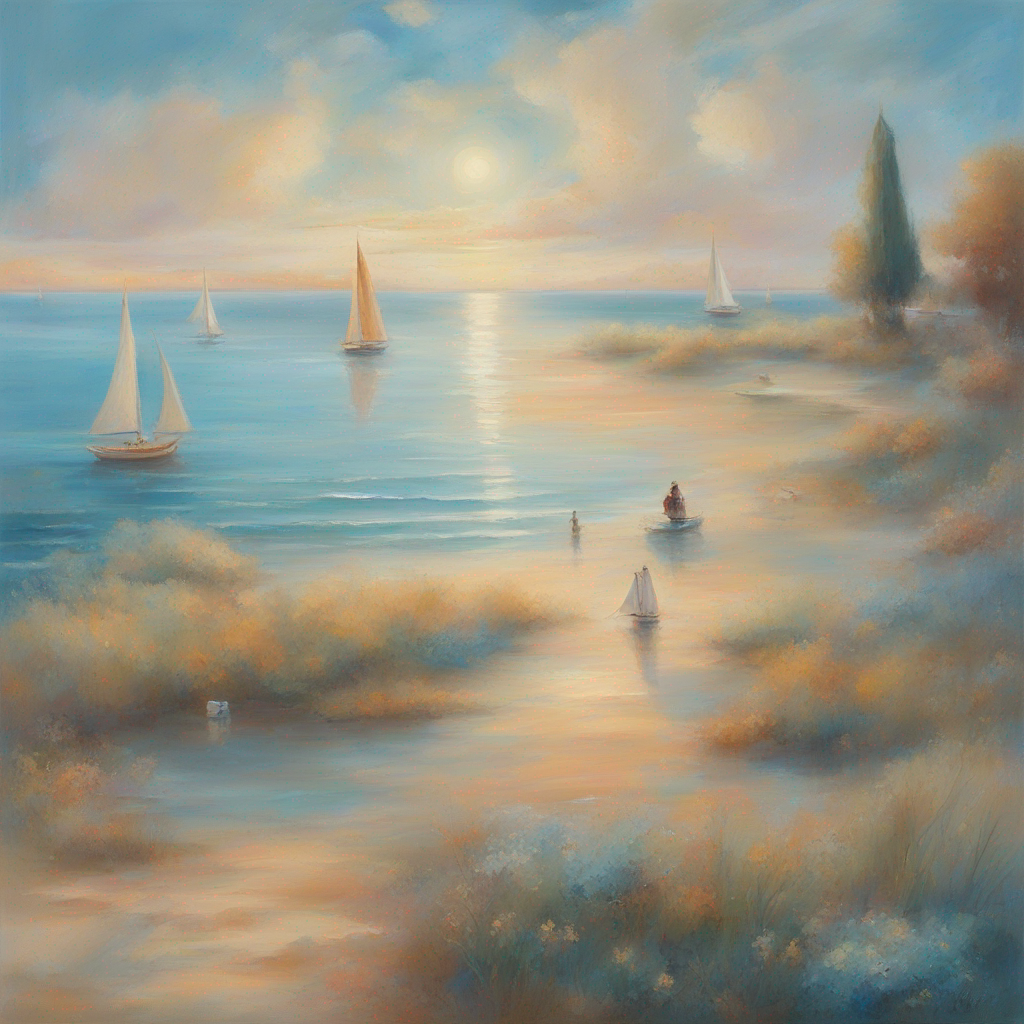

In [92]:
"""
用默认的python环境进行ui交互以及展示
"""
import time
time.sleep(3)
%cd /content
from yx_vars import refiner_png
from PIL import Image
img = Image.open(refiner_png)
img

# 其他调试工具


In [81]:
%env YXHAHA=/bin/bash
!echo $YXHAHA
!echo $SHELL  # 查看默认的shell是什么， 即%%shell用的什么

env: YXHAHA=/bin/bash
/bin/bash
/bin/bash


In [ ]:
"""
重启运行时
"""
import os
os.kill(os.getpid(), 9)